# Flight Delay & Cancellation Prediction During U.S. Summer Travel Season  
_Group 4 – STAT 628 Project | Jiapeng Wang, Yifan Chen, Zhixing Liu_

All code used in this project is available on GitHub:  
🔗 [https://github.com/Wwwwwjp/flight-cancel-delay-forecast](https://github.com/Wwwwwjp/flight-cancel-delay-forecast)

## Background

The period between **Memorial Day and Labor Day** marks the peak summer travel season in the United States. During this time, air traffic significantly increases as millions of passengers travel for vacations, family visits, and holidays.

However, the higher traffic volume, combined with unpredictable **weather conditions**, often leads to a rise in **flight delays and cancellations**. These disruptions cause inconvenience for passengers and can have operational and financial impacts on airlines.

In this project, we aim to analyze historical flight and weather data to uncover key patterns behind these disruptions. By building predictive models, we provide estimates for:

- The **probability of a flight being cancelled**
- The **expected delay duration** at both departure and arrival
- And finally, **recommendations** for travelers to help reduce the risk of disruptions

Our analysis focuses on U.S. domestic flights from **May to August 2024**, and incorporates both flight operation data from the **U.S. Department of Transportation** and weather data obtained via the **Meteostat** API.


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from meteostat import Point, Daily
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error, r2_score
import holidays
from sklearn.pipeline import Pipeline
import joblib
from statsmodels.stats.proportion import proportion_confint
from sklearn import set_config
set_config(display="text")  
from IPython.core.display import display, HTML
display(HTML("<style>pre { white-space: pre-wrap !important; }</style>"))

## Data Preprocessing

Our data preprocessing includes two main steps:

### 1. Initial Cleaning and Transformation (via R Script)

We used the instructor-provided R script to perform several basic preprocessing tasks on the original flight dataset, including:

- Re-encoding `DAY_OF_WEEK` and `CANCELLATION_CODE` for better readability
- Renaming columns to consistent and meaningful names
- Merging airport metadata (e.g., airport type, elevation, time zone)
- Converting all time-related variables (e.g., departure/arrival time) from local time to UTC

### 2. Weather Data Integration

To capture the impact of weather on flight disruptions, we enriched the dataset by adding historical weather data using the `meteostat` Python package. The weather data was matched to each flight record based on the departure airport’s location and scheduled time. Below is the code used to fetch weather conditions (e.g., temperature, precipitation, wind speed) to each airport, aligned with the scheduled flight time:

In [2]:
weather_cache = {}

def get_todays_forecast(lat, long, date, retries=3):
    key = (round(lat, 2), round(long, 2), date)
    if key in weather_cache:
        return weather_cache[key]

    for attempt in range(retries + 1):
        try:
            date_obj = datetime.strptime(date, '%Y-%m-%d')
            location = Point(lat, long)
            data = Daily(location, date_obj, date_obj).fetch()

            if data.empty:
                weather_cache[key] = None
                return None

            forecast = data.iloc[0]
            result = {
                "temperature_avg_C": forecast['tavg'],
                "temperature_min_C": forecast['tmin'],
                "temperature_max_C": forecast['tmax'],
                "precipitation_mm": forecast['prcp'],
                "wind_speed_kph": forecast['wspd'],
                "snow_mm": forecast['snow']
            }
            weather_cache[key] = result
            return result

        except Exception as e:
            if attempt < retries:
                time.sleep(1)
            else:
                weather_cache[key] = None
                return None

def process_row(index, row):
    origin = get_todays_forecast(row['Latitude_origin'], row['Longitude_origin'], row['DATE'])
    dest = get_todays_forecast(row['Latitude_dest'], row['Longitude_dest'], row['DATE'])

    result = {}
    if origin:
        result.update({f'origin_{k}': v for k, v in origin.items()})
    if dest:
        result.update({f'dest_{k}': v for k, v in dest.items()})
    return index, result

def parallel_weather_fetch(df, max_workers=10):
    results = {}
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_row, idx, row) for idx, row in df.iterrows()]
        for future in as_completed(futures):
            idx, result = future.result()
            results[idx] = result

    weather_df = pd.DataFrame.from_dict(results, orient='index')
    weather_df = weather_df.sort_index()
    return pd.concat([df.reset_index(drop=True), weather_df.reset_index(drop=True)], axis=1)


Due to the large volume of data, both the R-based and Python-based preprocessing steps were executed on the **CHTC (Center for High Throughput Computing)**.

The processed data is stored in the following **Google Drive folder**, which will be used directly in the next steps of our analysis:  
🔗 [Google Drive – Processed Data](https://drive.google.com/drive/folders/1aXDaMYt9esGaeYZpWL6yRjgCLvBKvA1F?usp=drive_link)

In [3]:
file_patterns = ['May_weather.csv', 'June_weather.csv', 'July_weather.csv', 'August_weather.csv']
dfs = []

for file in file_patterns:
    df = pd.read_csv(file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

### 3. Feature Selection through Visualization

To identify the most relevant features for prediction, we conducted exploratory data analysis and created visualizations to observe patterns in flight delays and cancellations.

We focused on key dimensions such as **time**, **airline**, **airport**, and **weather conditions**.  
Here are some representative examples from our visual analysis.

The visualizations shown here represent only a subset of our full exploratory analysis.  
The complete set of visualizations can be found in:  
🔗 `code/visualization.ipynb` on our GitHub repository.

In [4]:
import holidays
us_holidays = holidays.US()
df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)

df['DEP_HOUR'] = df['SCH_DEP_TIME'] // 100
df['ARR_HOUR'] = df['SCH_ARR_TIME'] // 100

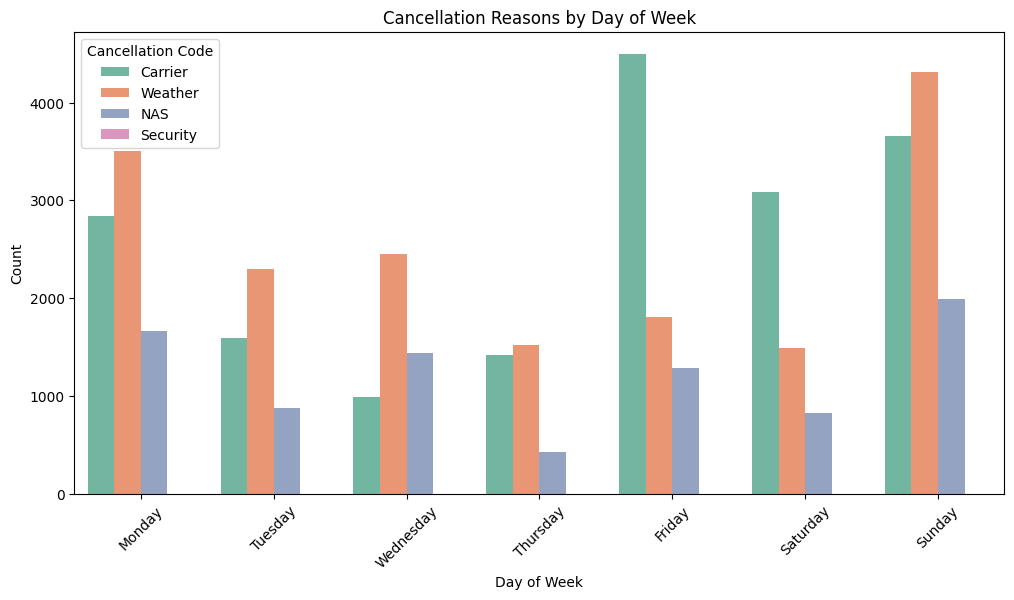

In [5]:
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
if "CANCELLATION_CODE" in df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=df[df["CANCELLED"] == 1],
        x="DAY_OF_WEEK",
        hue="CANCELLATION_CODE",
        palette="Set2"
    )
    plt.title("Cancellation Reasons by Day of Week", fontsize=12)
    plt.xlabel("Day of Week")
    plt.ylabel("Count")
    plt.xticks(ticks=range(7), labels=day_names, rotation=45)
    plt.legend(title="Cancellation Code")
    plt.show()

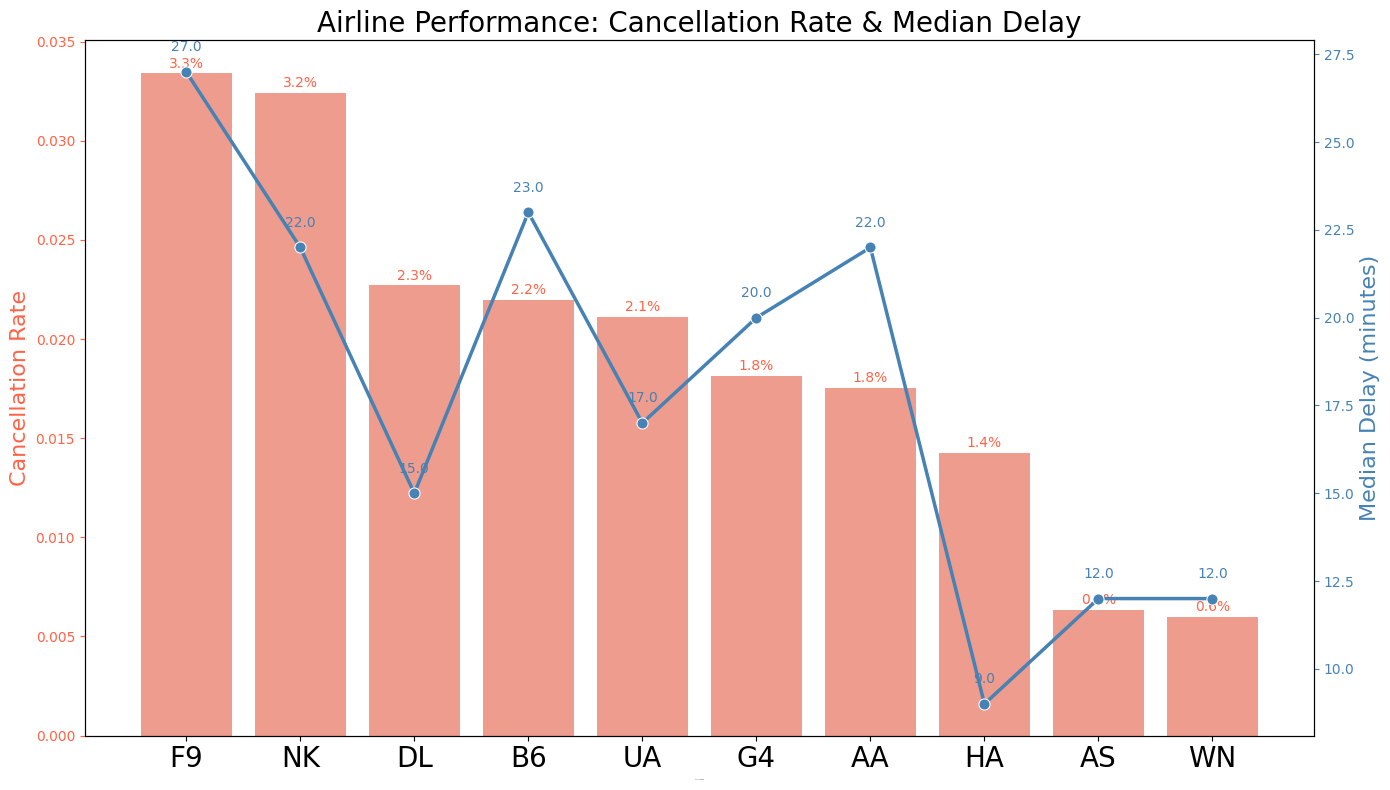

In [6]:
airline_stats = df.groupby('MKT_AIRLINE').agg(
    cancellation_rate=('CANCELLED', 'mean'),
    median_delay=('DEP_DELAY', lambda x: x[x >= 0].median()) 
).reset_index().sort_values('cancellation_rate', ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 8))

sns.barplot(
    data=airline_stats,
    x='MKT_AIRLINE',
    y='cancellation_rate',
    color='tomato',
    alpha=0.7,
    ax=ax1
)
ax1.set_title("Airline Performance: Cancellation Rate & Median Delay", fontsize=20)
ax1.set_xlabel("Airline Code", fontsize=0)
ax1.set_ylabel("Cancellation Rate", color='tomato', fontsize=16)
ax1.tick_params(axis='y', colors='tomato')
plt.xticks(rotation=0, fontsize = 20)

ax2 = ax1.twinx()
sns.lineplot(
    data=airline_stats,
    x='MKT_AIRLINE',
    y='median_delay',
    color='steelblue',
    marker='o',
    linewidth=2.5,
    markersize=8,
    ax=ax2
)
ax2.set_ylabel("Median Delay (minutes)", color='steelblue', fontsize=16)
ax2.tick_params(axis='y', colors='steelblue')

for p in ax1.patches:
    ax1.annotate(
        f"{p.get_height():.1%}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 7), 
        textcoords='offset points',
        color='tomato'
    )

for x, y in zip(range(len(airline_stats)), airline_stats['median_delay']):
    ax2.text(
        x, y+0.5, 
        f"{y:.1f}", 
        ha='center', va='bottom',
        color='steelblue'
    )

plt.tight_layout()
plt.show()

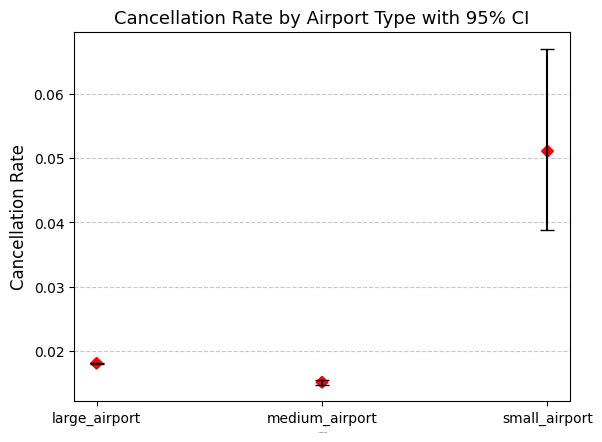

In [7]:
cancel_rates = df.groupby("ORIGIN_TYPE")["CANCELLED"].agg(
    rate=lambda x: np.mean(x),
    count=lambda x: len(x)
).reset_index()

conf_intervals = [proportion_confint(row["count"]*row["rate"], row["count"], method='wilson')
                 for _, row in cancel_rates.iterrows()]
cancel_rates["lower"], cancel_rates["upper"] = zip(*conf_intervals)

sns.pointplot(
    data=cancel_rates,
    x="ORIGIN_TYPE",
    y="rate",

    join=False,
    color='red',
    markers='D',
    scale=0.8
)

plt.errorbar(
    x=range(len(cancel_rates)),
    y=cancel_rates["rate"],
    yerr=[cancel_rates["rate"] - cancel_rates["lower"], cancel_rates["upper"] - cancel_rates["rate"]],
    fmt='none',
    ecolor='black',
    capsize=5
)

plt.title("Cancellation Rate by Airport Type with 95% CI", fontsize=13)
plt.xlabel("Airport Type", fontsize=0)
plt.ylabel("Cancellation Rate", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Modeling Approach

Based on the exploratory analysis and visualizations above, we selected several key features as inputs for our predictive models. These features were chosen based on their observed relationship with flight cancellations and delays.

In this section, we first introduce our **cancellation prediction model**.  
We then present the **modeling code** and the **feature importance results**, which help us understand which variables have the greatest impact on cancellation risk.

### 1. Cancellation Prediction Model

We framed cancellation prediction as a **binary classification task**, where the target variable indicates whether a flight was cancelled (`1`) or not (`0`).

We trained a tree-based model (XGBoost) for this task, which allows for robust handling of mixed feature types and provides interpretable feature importance metrics.

Below is the model training code and the corresponding feature importance plot.


In [8]:
select_features = ['DATE', 'WEEK', 'MKT_AIRLINE', 'ORIGIN_IATA', 'DEST_IATA', 'SCH_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 
                  'SCH_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'SCH_DURATION', 'DISTANCE', 'CARRIER_DELAY',
                  'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_TYPE','ORIGIN_ELEV',
                  'DEST_TYPE', 'DEST_ELEV', 'origin_temperature_avg_C', 'origin_temperature_min_C', 'origin_temperature_max_C',
                  'origin_precipitation_mm', 'origin_wind_speed_kph', 'origin_snow_mm', 'dest_temperature_avg_C',
                  'dest_temperature_min_C', 'dest_temperature_max_C', 'dest_precipitation_mm', 'dest_wind_speed_kph', 'dest_snow_mm']
df = df[select_features]
df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
us_holidays = holidays.US()
df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
df['DEP_HOUR'] = df['SCH_DEP_TIME'] // 100
df['ARR_HOUR'] = df['SCH_ARR_TIME'] // 100 
excluded = [
    'DATE',                  
    'CANCELLATION_CODE',     
    'DEP_DELAY',             
    'DEP_DELAY_NEW',         
    'ARR_DELAY',             
    'CARRIER_DELAY',         
    'WEATHER_DELAY',         
    'NAS_DELAY',             
    'SECURITY_DELAY',        
    'LATE_AIRCRAFT_DELAY'    
]
X = df.drop(columns=excluded + ['CANCELLED'])
y = df['CANCELLED']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
cat_features_te = ['ORIGIN_IATA', 'DEST_IATA', 'MKT_AIRLINE', 'DEP_HOUR', 'ARR_HOUR']        
cat_features_ohe = ['ORIGIN_TYPE', 'DEST_TYPE', 'WEEK']
num_features = [col for col in X.columns if col not in cat_features_te + cat_features_ohe]
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encode', TargetEncoder(), cat_features_te),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_features_ohe)
    ],
    remainder='passthrough'
)

cancelled_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]



In [9]:
# fit classification model
pipe_cancel_weather = Pipeline([
    ('preprocessor', preprocessor),
    ('classify', XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=cancelled_ratio,
    n_estimators=90,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
    ))
])

pipe_cancel_weather.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['ORIGIN_IATA', 'DEST_IATA',
                                                   'MKT_AIRLINE', 'DEP_HOUR',
                                                   'ARR_HOUR']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ORIGIN_TYPE', 'DEST_TYPE',
                                                   'WEEK'])])),
                ('classify',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsam...
                               feature_types=None, feature_weights=None,
                               gamma=

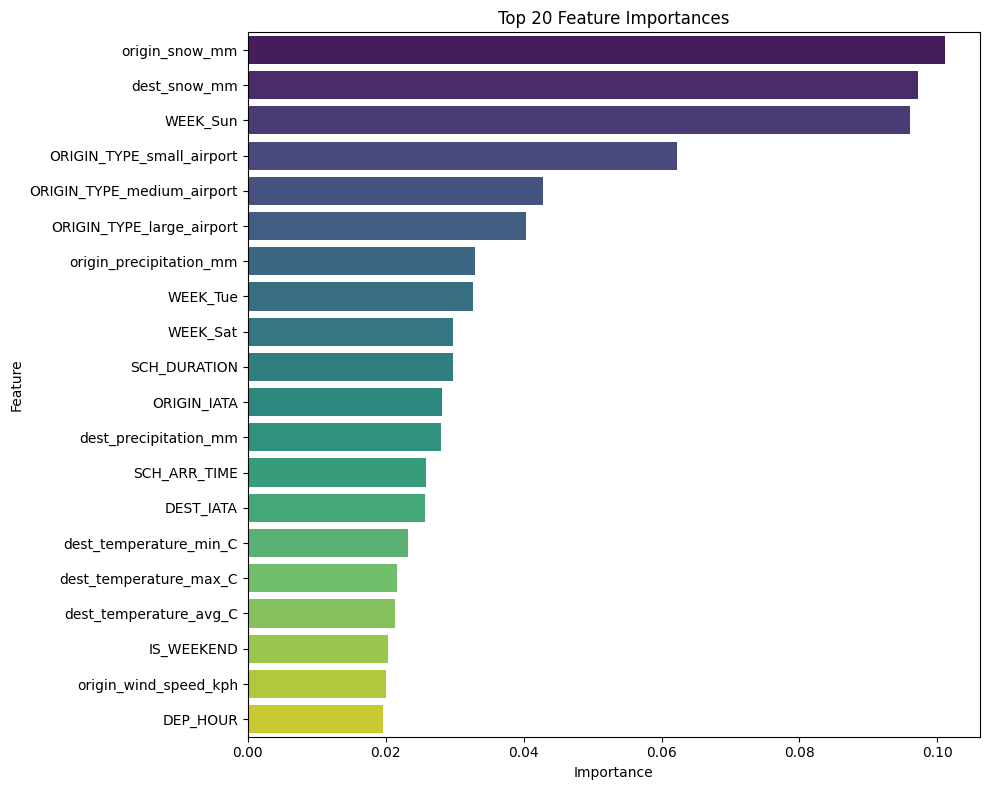

In [10]:
# Feature importance

ohe = preprocessor.named_transformers_['onehot']
ohe_feature_names = ohe.get_feature_names_out(cat_features_ohe)  

num_features = [col for col in X.columns if col not in cat_features_ohe]

feature_names = list(ohe_feature_names) + num_features

xgb_cancel = pipe_cancel_weather.named_steps['classify']
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_cancel.feature_importances_
})

top_20 = importance_df.sort_values(by='importance', ascending=False).head(20)

top_20_sorted = top_20.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")

plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

### 2. Delay Duration Prediction Models

We also built regression models to predict the **duration of flight delays**, for both departure and arrival.

This task was framed as a **regression problem**, where the target variable is the delay time (in minutes). We trained separate models for:

- **Departure Delay (`DEP_DELAY`)**
- **Arrival Delay (`ARR_DELAY`)**

We applied a tree-based regression model (XGBoost Regressor) for its ability to capture non-linear relationships and feature interactions.

Below is the model training code and the resulting feature importance plot.


In [11]:
select_features = ['DATE', 'WEEK', 'MKT_AIRLINE', 'ORIGIN_IATA', 'DEST_IATA', 'SCH_DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 
                  'SCH_ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'SCH_DURATION', 'DISTANCE', 'CARRIER_DELAY',
                  'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_TYPE','ORIGIN_ELEV',
                  'DEST_TYPE', 'DEST_ELEV', 'origin_temperature_avg_C', 'origin_temperature_min_C', 'origin_temperature_max_C',
                  'origin_precipitation_mm', 'origin_wind_speed_kph', 'origin_snow_mm', 'dest_temperature_avg_C',
                  'dest_temperature_min_C', 'dest_temperature_max_C', 'dest_precipitation_mm', 'dest_wind_speed_kph', 'dest_snow_mm']
df = df[select_features]
df['IS_WEEKEND'] = df['WEEK'].isin(['Sat', 'Sun']).astype(int)
us_holidays = holidays.US()
df['IS_HOLIDAY'] = df['DATE'].isin(us_holidays).astype(int)
df['DEP_HOUR'] = df['SCH_DEP_TIME'] // 100
df['ARR_HOUR'] = df['SCH_ARR_TIME'] // 100
df = df.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])

def find_outlier_indices(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)].index
dep_delay_outlier_indices = find_outlier_indices(df['DEP_DELAY'])
arr_delay_outlier_indices = find_outlier_indices(df['ARR_DELAY'])
outlier_indices = dep_delay_outlier_indices.union(arr_delay_outlier_indices)
df = df.drop(index=outlier_indices)
excluded_features = [
    'DATE',                  
    'CANCELLED',             
    'CANCELLATION_CODE',     
    'DEP_DELAY_NEW',         
    'CARRIER_DELAY',         
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'ARR_DELAY',
    'DEP_DELAY'              
]

features = df.drop(columns=excluded_features)
target_dep_delay = df['DEP_DELAY']
target_arr_delay = df['ARR_DELAY']
cat_features_te = ['ORIGIN_IATA', 'DEST_IATA', 'MKT_AIRLINE', 'DEP_HOUR', 'ARR_HOUR']          
cat_features_ohe = ['ORIGIN_TYPE', 'DEST_TYPE', 'WEEK'] 
num_features = [col for col in features.columns if col not in cat_features_te + cat_features_ohe]

preprocessor = ColumnTransformer(
    transformers=[
        ('target_encode', TargetEncoder(), cat_features_te),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_features_ohe)
    ],
    remainder='passthrough'
)

X_dep_train, X_dep_test, y_dep_train, y_dep_test = train_test_split(
    features, target_dep_delay, test_size=0.2, random_state=42
)

pipe_dep_weather = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=90,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipe_dep_weather.fit(X_dep_train, y_dep_train)

X_arr_train, X_arr_test, y_arr_train, y_arr_test = train_test_split(
    features, target_arr_delay, test_size=0.2, random_state=42
)

pipe_arr_weather = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=90,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipe_arr_weather.fit(X_arr_train, y_arr_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target_encode',
                                                  TargetEncoder(),
                                                  ['ORIGIN_IATA', 'DEST_IATA',
                                                   'MKT_AIRLINE', 'DEP_HOUR',
                                                   'ARR_HOUR']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ORIGIN_TYPE', 'DEST_TYPE',
                                                   'WEEK'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsam...
                              feature_types=None, feature_weights=None,
                              gamma=Non

In [12]:
y_dep_pred = pipe_dep_weather.predict(X_dep_test)
y_arr_pred = pipe_arr_weather.predict(X_arr_test)

mse_dep = mean_squared_error(y_dep_test, y_dep_pred)
print(f"MSE for departure delay model: {mse_dep:.2f}")

mse_arr = mean_squared_error(y_arr_test, y_arr_pred)
print(f"MSE for arrival delay model: {mse_arr:.2f}")

MSE for departure delay model: 136.02
MSE for arrival delay model: 219.87


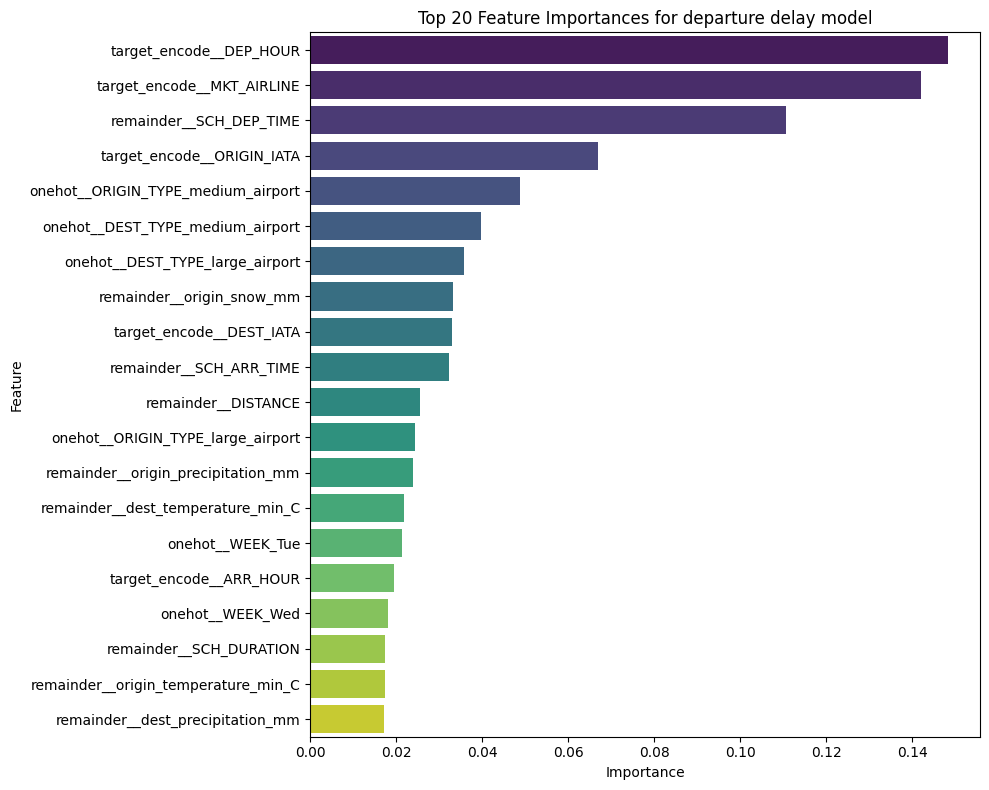

In [13]:
# Feature importance for departure delay model

feature_names_dep = pipe_dep_weather.named_steps['preprocessor'].get_feature_names_out()
xgb_model_dep = pipe_dep_weather.named_steps['regressor']
importances_dep = xgb_model_dep.feature_importances_
feature_importance_dep = pd.DataFrame({
    'feature': feature_names_dep,
    'importance': importances_dep
}).sort_values(by='importance', ascending=False)

top_20 = feature_importance_dep.sort_values(by='importance', ascending=False).head(20)

top_20_sorted = top_20.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")

plt.title("Top 20 Feature Importances for departure delay model")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

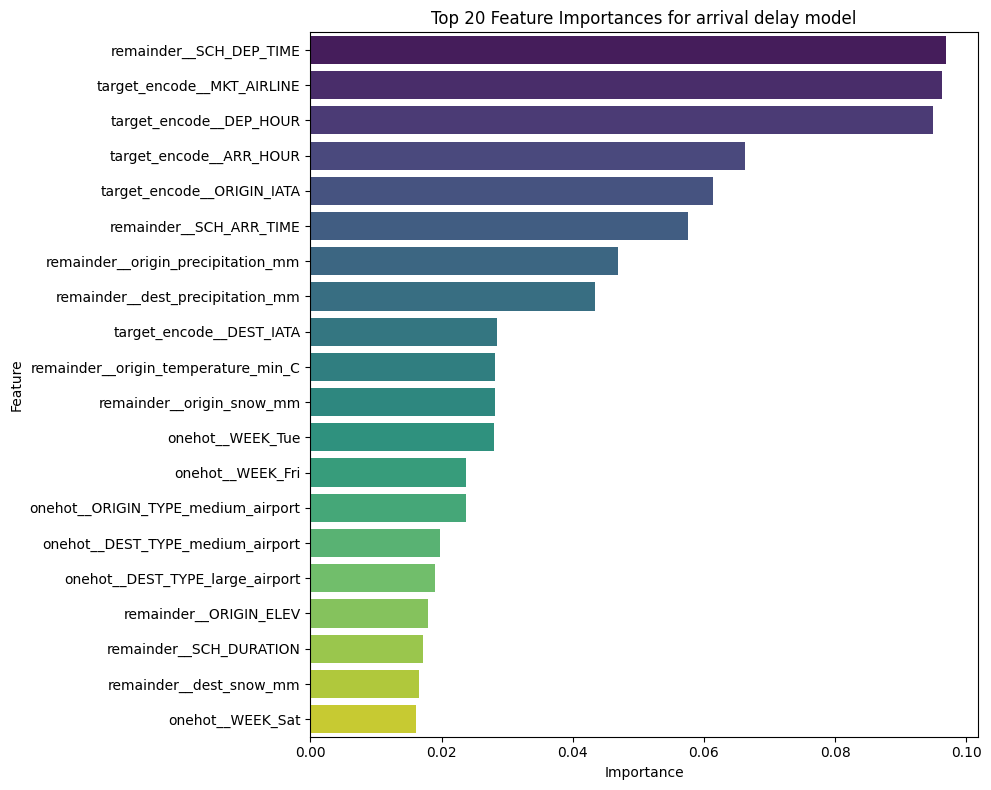

In [14]:
feature_names_arr = pipe_arr_weather.named_steps['preprocessor'].get_feature_names_out()
xgb_model_arr = pipe_arr_weather.named_steps['regressor']
importances_arr = xgb_model_arr.feature_importances_
feature_importance_arr = pd.DataFrame({
    'feature': feature_names_arr,
    'importance': importances_arr
}).sort_values(by='importance', ascending=False)

top_20 = feature_importance_arr.sort_values(by='importance', ascending=False).head(20)

top_20_sorted = top_20.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x="importance", y="feature", data=top_20_sorted, palette="viridis")

plt.title("Top 20 Feature Importances for arrival delay model")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()

### 3. Backup Models Without Weather Features

The models presented above rely on weather-related features such as temperature, precipitation, wind speed, and visibility.  
However, in real-world scenarios—especially when users input a future flight time—**weather forecasts may not be available** or may be unreliable.

To address this issue, we trained **alternative models that exclude weather variables**. These backup models are designed to make predictions based only on flight schedule, airline, and airport characteristics.

These weather-free models are automatically used in our Shiny application **when weather data is unavailable**, ensuring that users always receive a prediction, even with limited input.

This design increases the **robustness and usability** of our application in real-world travel planning.


## Results & Recommendations

### Main Drivers of Flight Cancellation

Based on our analysis, the **most significant factor contributing to flight cancellations is snowfall** at both the departure and arrival airports.  
In addition, flights departing from **small airports** and those scheduled on **Sundays** are more likely to be canceled.  
Flights departing from **medium-sized airports** also show a moderate risk of cancellation, but not as high as the above factors.

---

### Main Drivers of Flight Delays

Surprisingly, **weather is not the most important factor** influencing delays.  
Instead, the **airline**, **scheduled departure time**, and **departure airport** play the biggest roles in both departure and arrival delays.

- For **departure delays**, flying from a **medium-sized airport** is a moderately important factor.
- For **arrival delays**, **precipitation at the destination airport** has a noticeable impact.

---

### Travel Recommendations

Based on our findings, we offer the following advice to reduce the risk of flight disruptions:

- **To avoid cancellations**:
  - Avoid flying on days with **heavy snowfall**
  - When possible, choose **larger airports** over small regional ones
  - Be cautious with flights scheduled on **Sundays**

- **To reduce delay risks**:
  - Prefer flights operated by **major airlines** (e.g., AA, DL, UA)
  - Choose departure airports with **better historical performance** (typically large or hub airports)
  - Avoid flights scheduled during **peak afternoon hours**, when delays are more likely

- **For connecting flights**:
  - Avoid **short layovers**; allow enough buffer time between flights to accommodate possible delays on the first leg

These recommendations are integrated into our Shiny application to help users make more informed travel decisions.


## Shiny Application: SkyCast

**SkyCast** is a Shiny-based web application designed to help users **predict potential flight delays and cancellations** with minimal input.  
Our core goal is to prioritize **user convenience** without compromising prediction **accuracy**.

During prediction, users only need to enter basic flight details such as:
- Departure and arrival airports
- Date and time
- Carrier

All other key variables—such as **weather**, **airport type**, **elevation**, and **distance**—are computed automatically based on user input.  
This ensures a **clean and user-friendly interface** while still using all necessary information for accurate predictions.

The app uses two types of models:
- **Weather-based models** for flights within the next week, using real-time weather data via API
- **Non-weather models** for flights further in the future, ensuring predictions are always available

In addition, the app includes a **Travel Advice panel** that provides personalized recommendations, based on both model results and historical analysis—such as suggesting more reliable airlines or avoiding peak travel days.

You can try the app here:  
🔗 [SkyCast Shiny App](https://yifanchenfp.shinyapps.io/shiny-py/)

The full application code is available on GitHub:  
🔗 [GitHub – flight-cancel-delay-forecast](https://github.com/Wwwwwjp/flight-cancel-delay-forecast)


## Limitations and Future Work

While our project provides a practical tool for predicting flight delays and cancellations, there are several limitations worth noting:

- **Data Limitations**:  
  Our analysis is based on historical flight and weather data from **May to August 2024**.  
  As such, the model may not generalize well to other seasons or special events (e.g., holidays, natural disasters).

- **Weather Forecast Accuracy**:  
  Real-time weather data can be volatile, and predictions based on short-term forecasts may still be affected by rapid changes in local conditions.

- **Model Assumptions**:  
  The models assume that all input features are accurate and independent.  
  In reality, **operational issues, air traffic control**, and **unexpected events** can significantly affect flight outcomes but are not captured in the data.

- **Simplified User Input**:  
  While the Shiny app interface is intentionally minimal, users still need to manually input flight time and carrier.  
  This can be inconvenient or error-prone, especially for lay users.

---

### Future Improvements

To address these limitations and enhance the tool’s usability, we propose the following future enhancements:

-  **Expand the dataset** to cover all seasons and multiple years for more robust, year-round predictions  
-  **Integrate flight schedule APIs** to automatically retrieve departure times based on airport code and flight number  
-  **Develop a mobile-friendly interface** to improve accessibility for on-the-go users  
-  **Experiment with deep learning models** for potentially improved prediction accuracy, especially under complex interactions

Our current system balances interpretability, usability, and performance. These improvements aim to make it even more practical and reliable for real-world travel planning.
